# Import and Read

In [193]:
# wide screen
from IPython.core.display import display, HTML
from IPython import get_ipython as get_ipython
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important;margin-left:-30px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

In [1]:
import math

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from random import randint
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [324]:
df = pd.read_csv('./data/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']

In [325]:
df.loc[8314:65671, 'Ebeam'] = 5.754

In [326]:
df['phi'] = df.phi.apply(lambda x: math.radians(x))

# Preprocessing (remove soft dups)

In [327]:
df.head()

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,id
0,1.515,1.11,0.3,0.991445,0.261799,15.370,5.264366,E8M1
1,1.515,1.11,0.3,0.991445,0.785398,4.511,1.743136,E8M1
2,1.515,1.11,0.3,0.991445,1.308997,4.478,1.611260,E8M1
3,1.515,1.11,0.3,0.991445,1.832596,5.136,1.523529,E8M1
4,1.515,1.11,0.3,0.991445,2.356194,5.078,1.219442,E8M1


#### problem

In [328]:
df[(df.Ebeam == 5.754)&
  (df.W == 1.27)&
  (df.Q2 == 2.05)&
  (df.cos_theta == 0.9)&
  (df.phi == 0.1308996938995747)]

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,id
15346,5.754,1.27,2.05,0.9,0.1309,1.72870,0.10616,E13M44
53610,5.754,1.27,2.05,0.9,0.1309,1.17904,0.07595,E14M35


In [329]:
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]

#### One more problem

In [391]:
df.groupby(['Ebeam', 'W', 'Q2', 'cos_theta', 'id']).count().sort_values('phi', ascending=False).reset_index().iloc[0]

Ebeam               5.499
W                    1.95
Q2                    2.6
cos_theta           0.875
id               E141M141
phi                    48
dsigma_dOmega          48
error                  48
Name: 0, dtype: object

In [392]:
df_max_example_set = df[(df.Ebeam == 5.499)&
                       (df.W == 1.95)&
                       (df.Q2 == 2.6)&
                       (df.cos_theta == 0.875)].sort_values('phi')

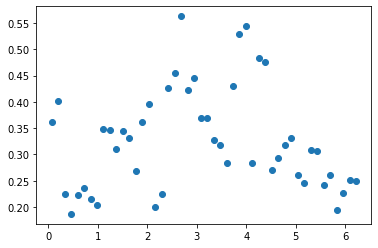

In [394]:
plt.scatter(x=df_max_example_set.phi, 
            y=df_max_example_set.dsigma_dOmega)

# XGB

In [25]:
# Extract the features and target column
X = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']]
y = df['dsigma_dOmega']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=50000,)
#                              max_depth=100, 
#                              learning_rate=0.01, 
#                              n_jobs=-1, 
#                              verbosity=1)
xgb_model.fit(X_train, y_train)

# Make predictions on the testing set and calculate the mean squared error
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Mean Squared Error: 0.27517245169183663


# Find fixed ['Ebeam', 'W', 'Q2', 'cos_theta'] max statistics for validatetion

In [412]:
max_stat_example = df.groupby(['Ebeam', 'W', 'Q2', 'cos_theta']).\
                    count().sort_values('cos_theta', ascending=False).reset_index().iloc[1414].to_dict()

df_max_example_set = df[(df.Ebeam == max_stat_example['Ebeam'])&
                       (df.W == max_stat_example['W'])&
                       (df.Q2 == max_stat_example['Q2'])&
                       (df.cos_theta == max_stat_example['cos_theta'])].sort_values('phi')

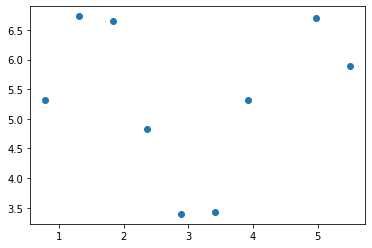

In [413]:
plt.scatter(x=df_max_example_set.phi, 
            y=df_max_example_set.dsigma_dOmega)

# Predict according to fixed ['Ebeam', 'W', 'Q2', 'cos_theta']

In [382]:
df_test_fixed = pd.DataFrame({'Ebeam' : [max_stat_example['Ebeam'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                              'W' : [max_stat_example['W'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                              'Q2' : [max_stat_example['Q2'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                              'cos_theta' : [max_stat_example['cos_theta'] for _ in np.arange(0, 2*np.pi, 0.01)],
                              'phi' : [phi for phi in np.arange(0, 2*np.pi, 0.01)]})

In [383]:
dsigma_dOmega_predicted = xgb_model.predict(df_test_fixed)

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Fit a + b * cos(2*phi) + c * cos(phi) 

In [414]:
 #define the function 
def func_cos(x, a, b, c): 
    return a + b*np.cos(2*x) + c*np.cos(x) 
 
#input data 
xdata = df_max_example_set.phi
ydata = df_max_example_set.dsigma_dOmega 
 
#fitting the data 
popt, pcov = curve_fit(func_cos, xdata, ydata, p0= [0, 1, 2]) 
 
a, b, c = popt[0], popt[1], popt[2]
#print the fitted parameters 
print("a = %s , b = %s, c = %s" % (a, b, c))

a = 5.281502193047906 , b = -1.633922331862747, c = 0.407366826916384


In [415]:
phi_theory = [i for i in np.arange(0, 2*np.pi, 0.01)]
dsigma_dOmega_theory = [func(x, a, b, c) for x in phi_theory]

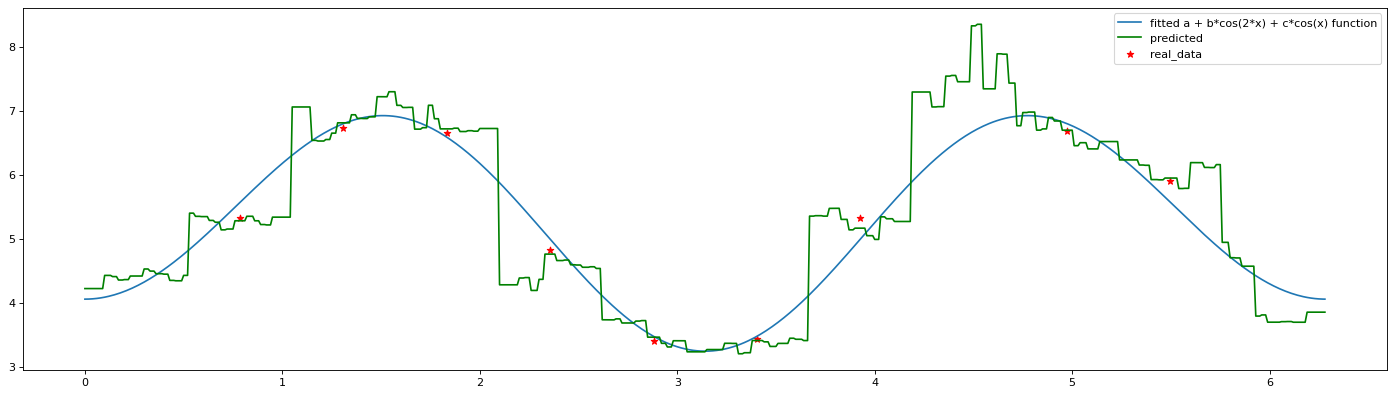

In [416]:
plt.figure(figsize=(22, 6), dpi=80)
plt.plot(phi_theory, 
         dsigma_dOmega_theory, 
         label=f'fitted a + b*cos(2*x) + c*cos(x) function')
plt.plot(phi_theory, 
         dsigma_dOmega_predicted, 
         color='green', label=f'predicted')
plt.scatter(x=df_max_example_set.phi, 
            y=df_max_example_set.dsigma_dOmega, 
            color='red', marker='*', label='real_data')
plt.legend()

# Same but 20 examples 

In [432]:
def rundom_example_check(df, number):
    example = df.iloc[number][['Ebeam', 'W', 'Q2', 'cos_theta']]
    
    df_example_set = df[(df.Ebeam == example['Ebeam'])&
                       (df.W == example['W'])&
                       (df.Q2 == example['Q2'])&
                       (df.cos_theta == example['cos_theta'])].sort_values('phi')
    
    df_example_set_for_prediction = pd.DataFrame({'Ebeam' : [example['Ebeam'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                                                  'W' : [example['W'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                                                  'Q2' : [example['Q2'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                                                  'cos_theta' : [example['cos_theta'] for _ in np.arange(0, 2*np.pi, 0.01)],
                                                  'phi' : [phi for phi in np.arange(0, 2*np.pi, 0.01)]})

#     return df_example_set
    
    dsigma_dOmega_predicted = xgb_model.predict(df_example_set_for_prediction)
     
    def func_cos(x, a, b, c): 
        return a + b*np.cos(2*x) + c*np.cos(x) 

    #input data 
    xdata = df_example_set.phi
    ydata = df_example_set.dsigma_dOmega 

    #fitting the data 
    popt, pcov = curve_fit(func_cos, xdata, ydata) 

    a, b, c = popt[0], popt[1], popt[2]
    #print the fitted parameters 
    print("a = %s , b = %s, c = %s" % (a, b, c))
    phi_theory = [i for i in np.arange(0, 2*np.pi, 0.01)]
    dsigma_dOmega_theory = [func_cos(x, a, b, c) for x in phi_theory]
    
    plt.figure(figsize=(22, 6), dpi=80)
    plt.plot(phi_theory, 
             dsigma_dOmega_theory, 
             label=f'fitted a + b*cos(2*x) + c*cos(x) function')
    plt.plot(df_example_set_for_prediction.phi, 
             dsigma_dOmega_predicted, 
             color='green', label=f'predicted')
    plt.scatter(x=df_example_set.phi, 
                y=df_example_set.dsigma_dOmega, 
                color='red', marker='*', label='real_data')
    plt.legend()
    plt.show()

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


a = 0.16769163454374525 , b = 0.002947779618880819, c = -0.0007385264120902679


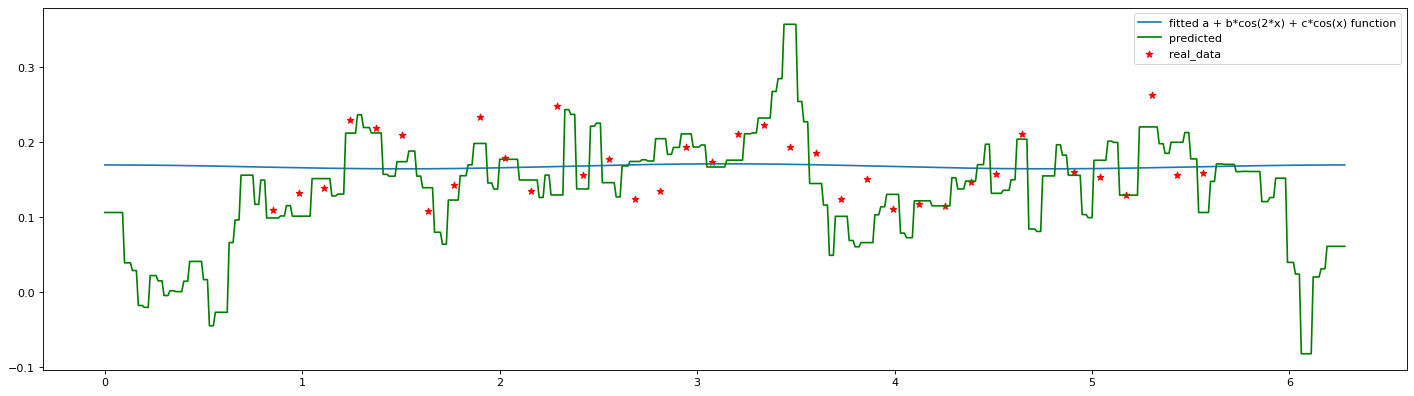

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


a = 1.4233515318132794 , b = -0.49530424698853204, c = -0.37220916589692954


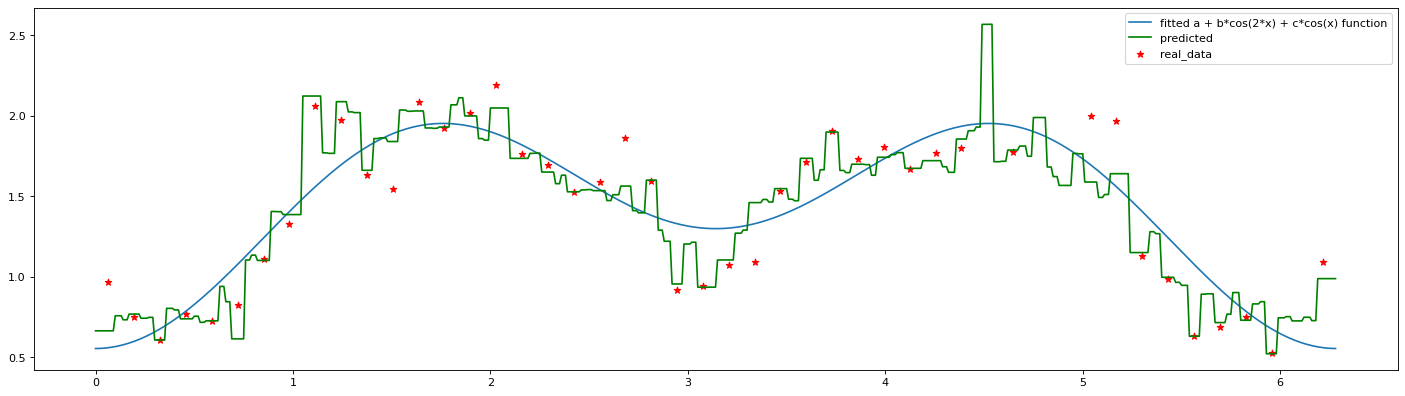

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


a = 0.456878550991737 , b = -0.04877122230270057, c = -0.03669301990332191


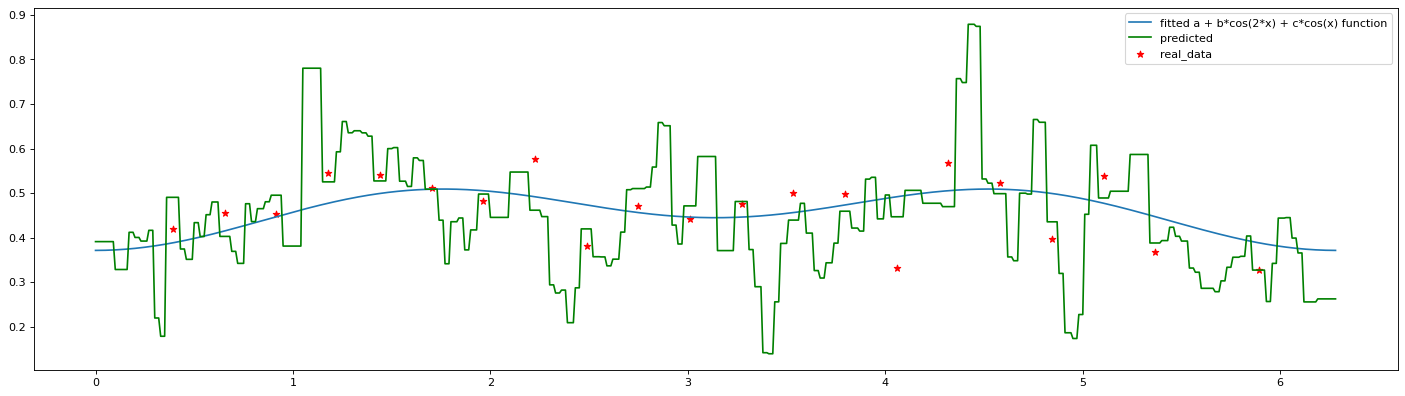

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


a = 11.592526231318322 , b = -3.7339674352429526, c = -1.7616861888056774


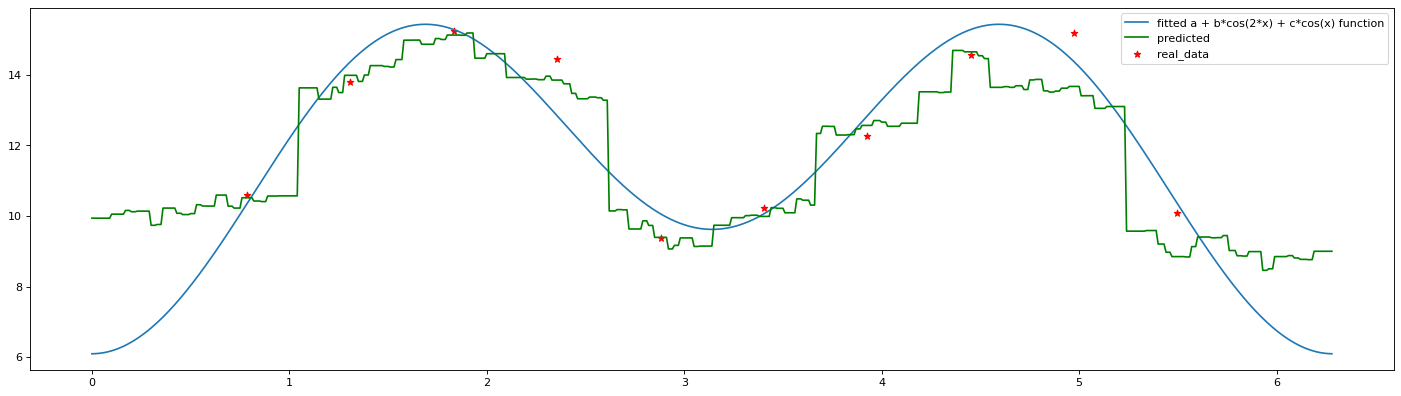

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


a = 1.8279738207116742 , b = -0.2947937234964464, c = 0.23389232557525244


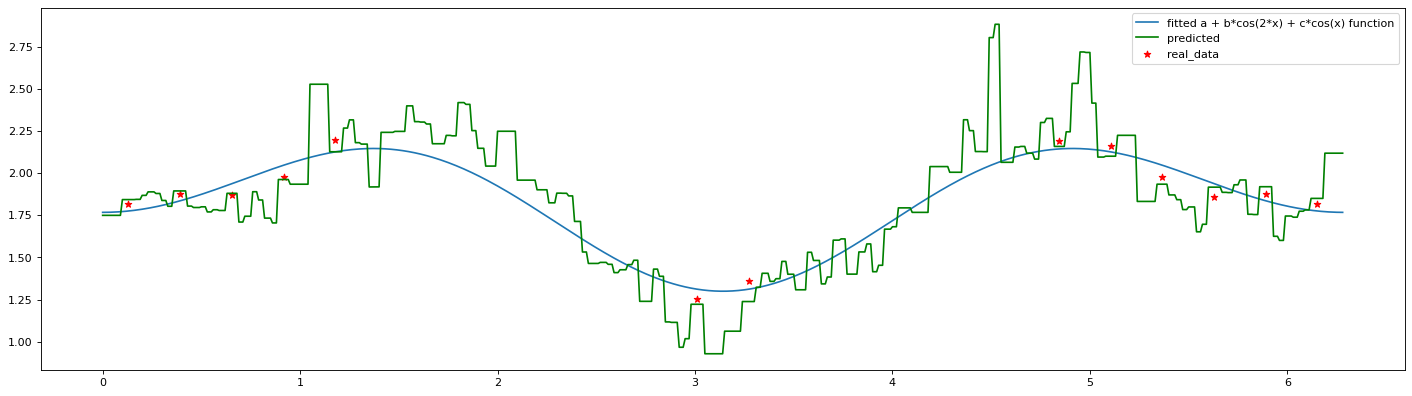

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


a = 0.41505188899151624 , b = 0.004993714760380138, c = -0.040935228799322015


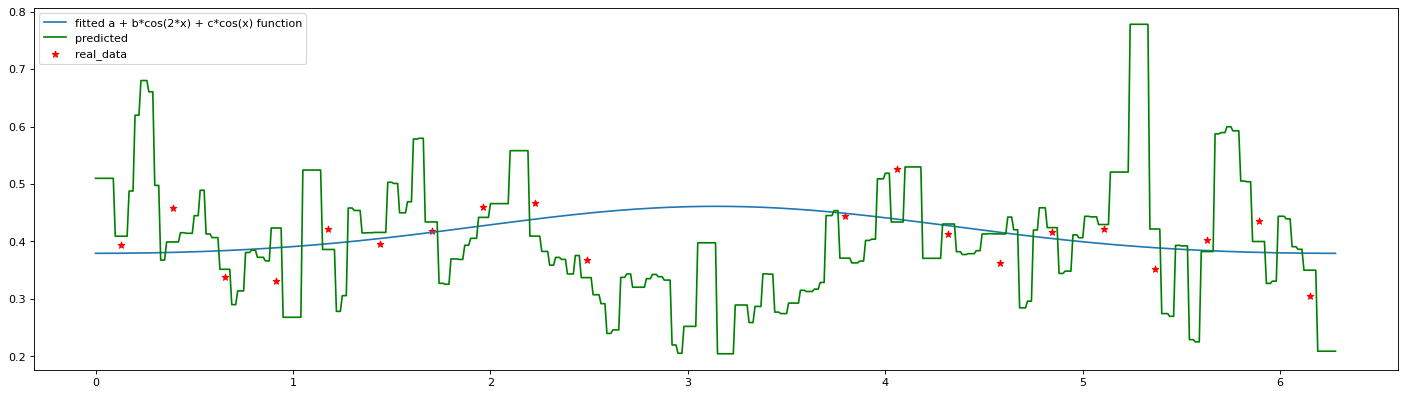

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


a = 5.141455429663728 , b = -2.0385566634120678, c = -1.5076530251885487


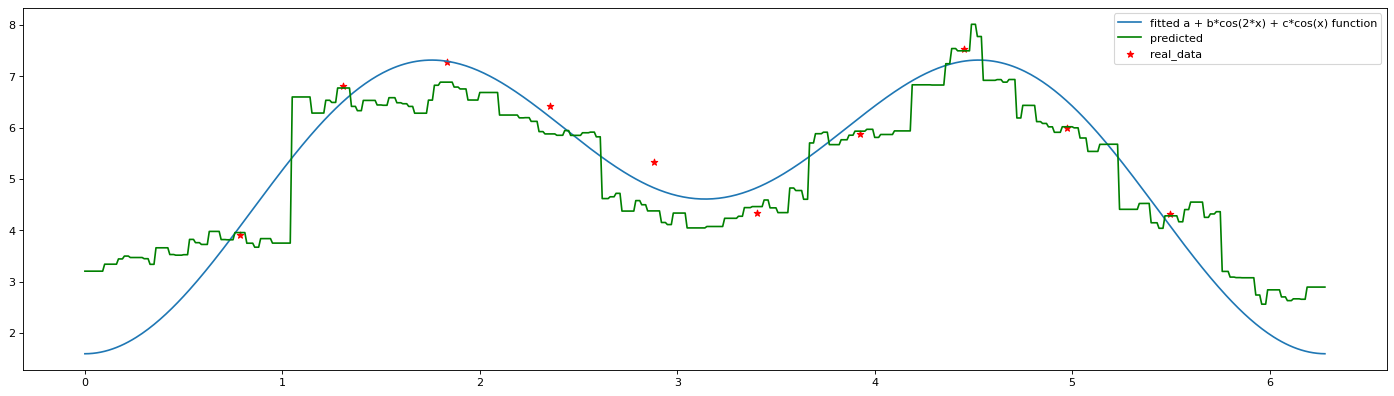

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


a = 0.18443416669728133 , b = -0.03753747200128558, c = 0.018153076732802035


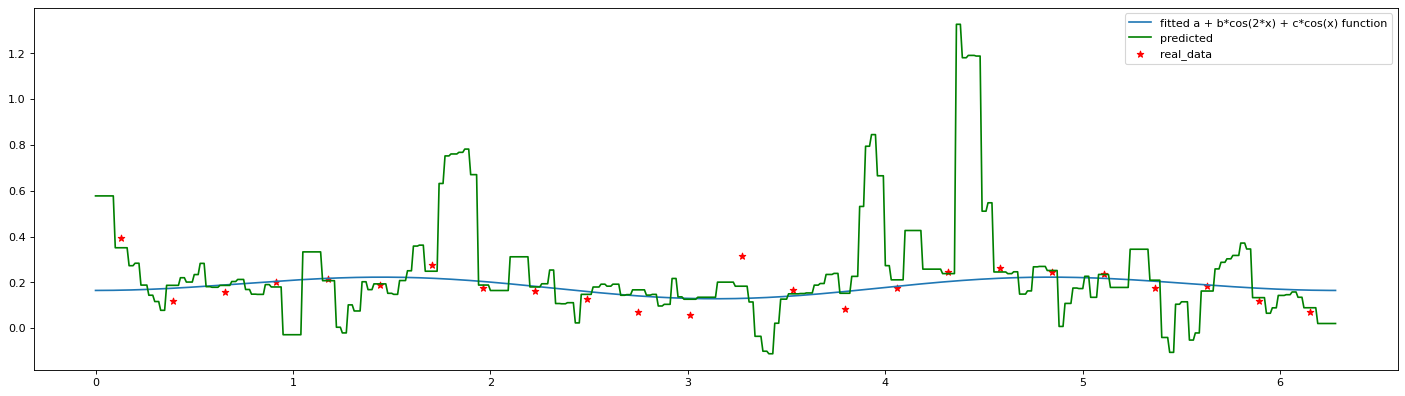

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


a = 0.2977529379521753 , b = -0.009924121071660264, c = -0.03927141997692111


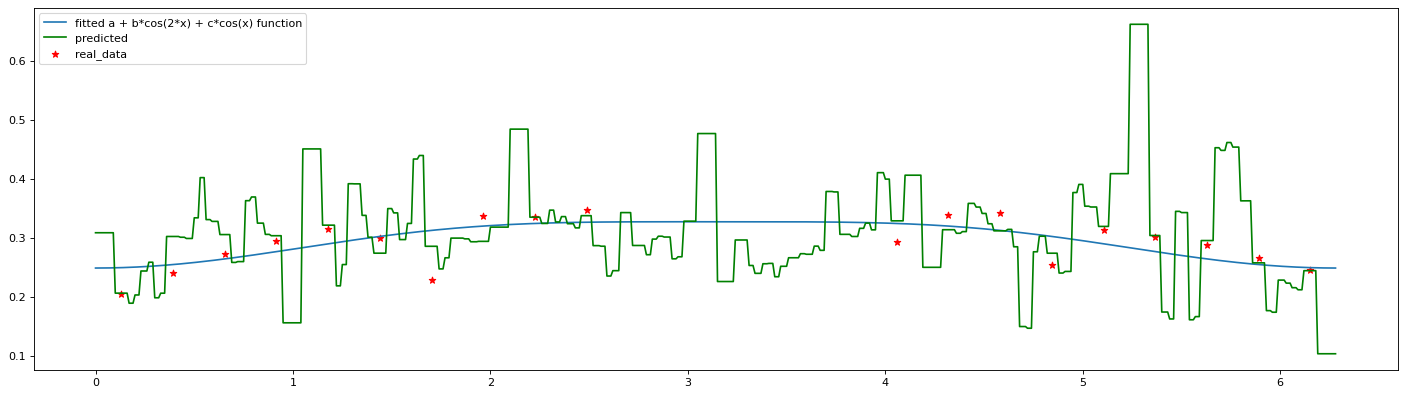

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


a = 0.5881416666666667 , b = -0.02642820857215532, c = 0.06755332232101104


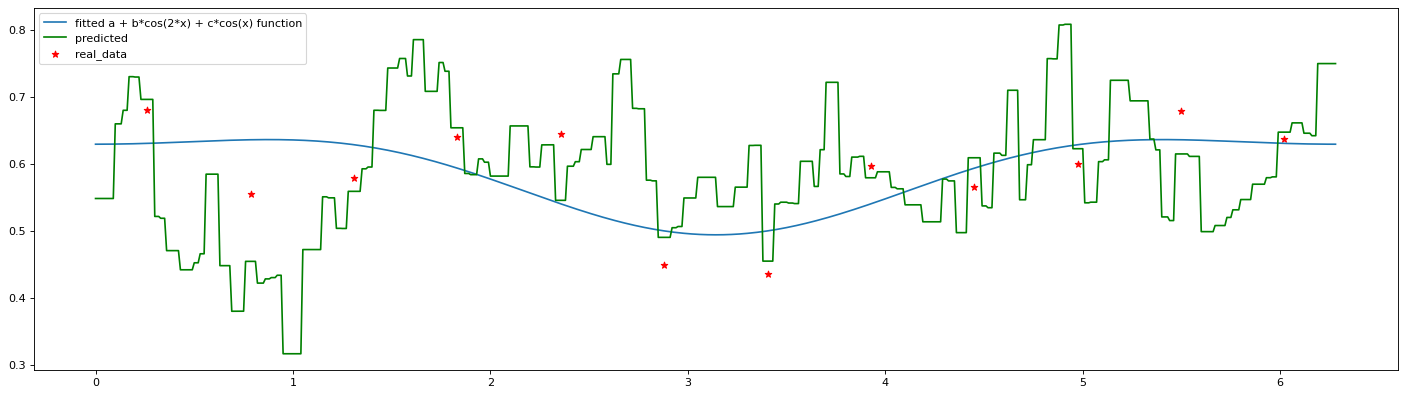

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


a = 0.2822462500000001 , b = 0.03136707141873437, c = 0.0394632189283895


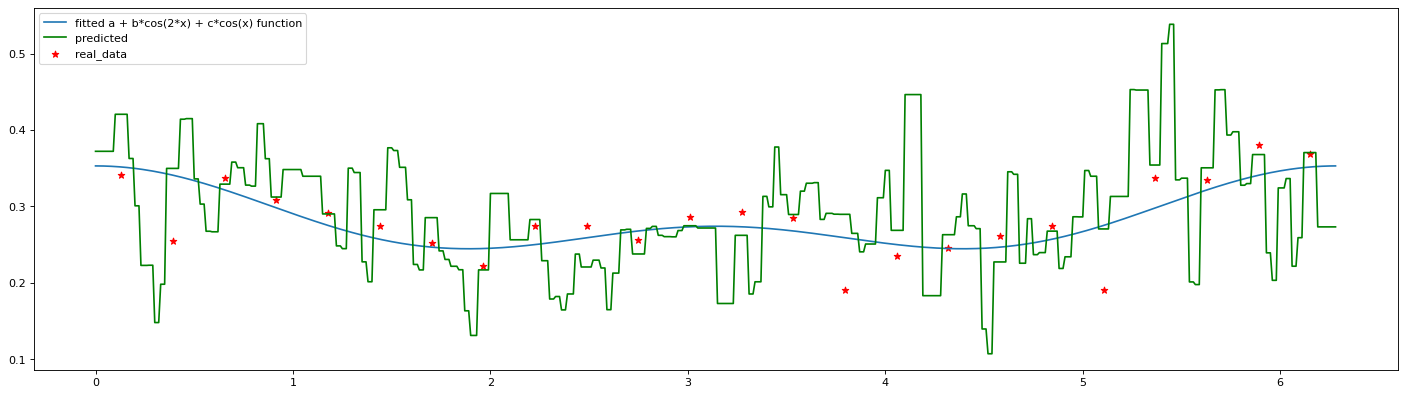

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


a = 0.8588854166666667 , b = -0.05033831573504195, c = -0.01282253171878925


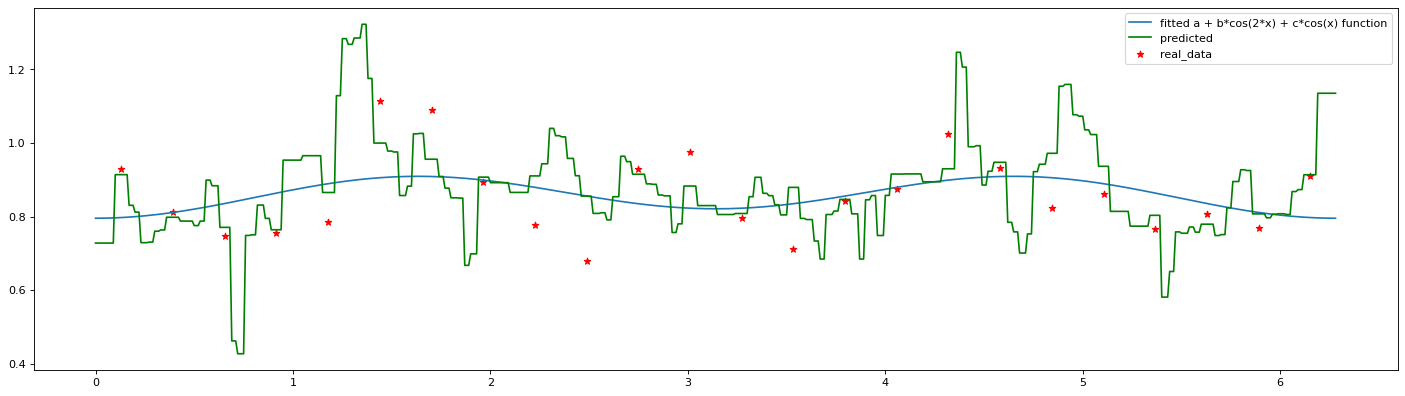

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


a = 1.9298791143353988 , b = -0.8676781592200743, c = -0.523567013228562


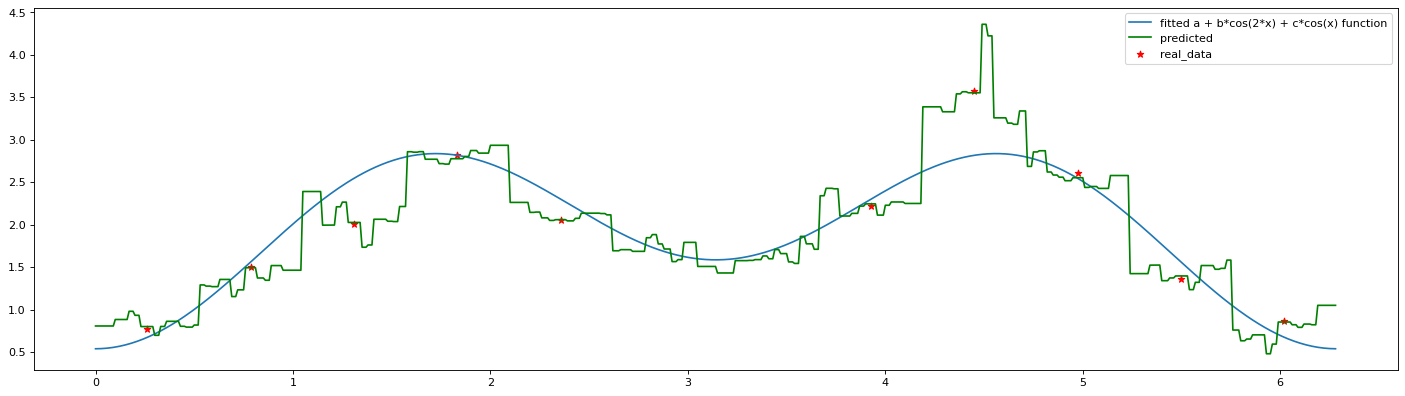

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


a = 0.12902400399311387 , b = -0.1005761419585987, c = -0.016542145743756047


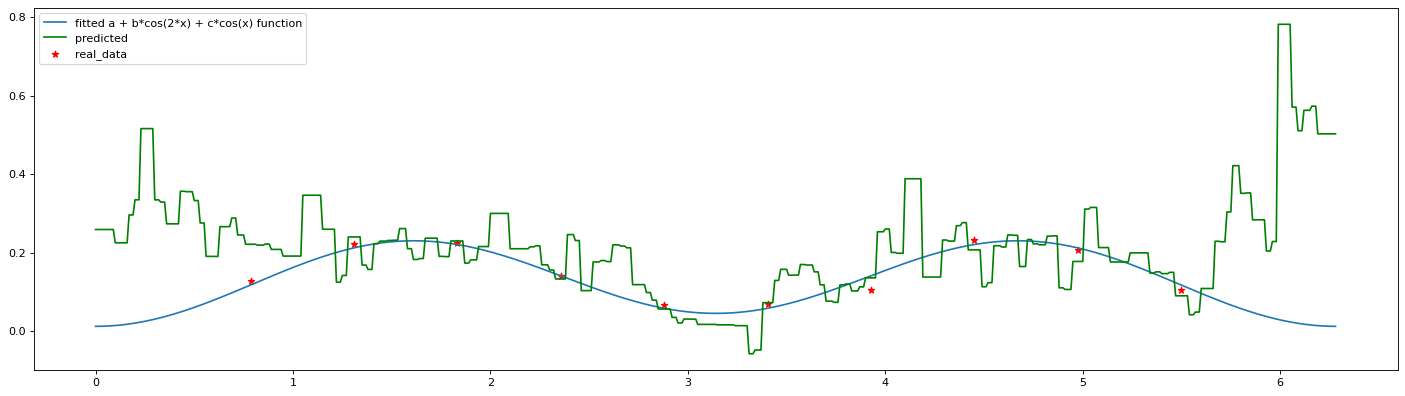

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


a = 0.2981718372531684 , b = -0.14253559963134602, c = -0.07078421408513139


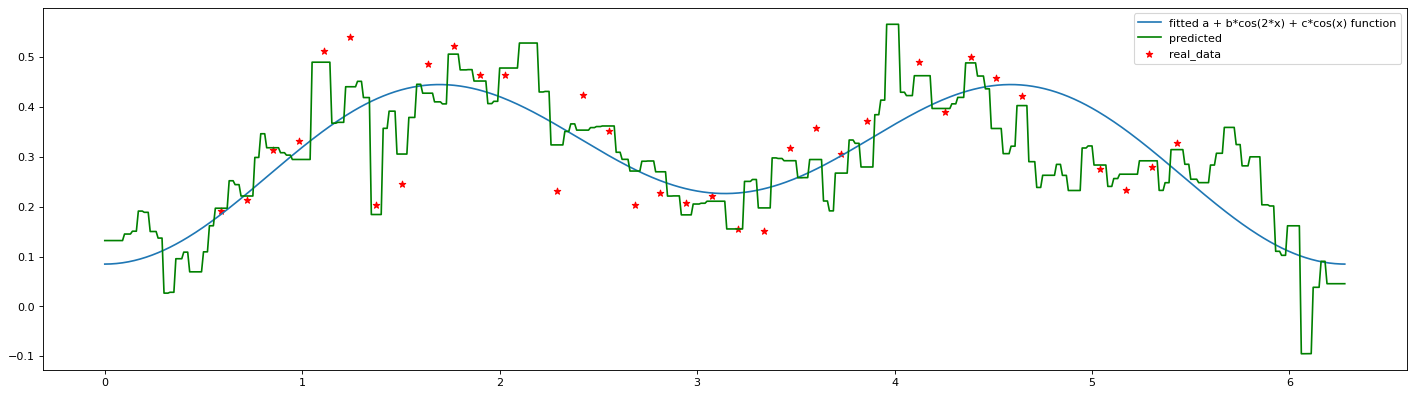

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


a = 0.1697530038920213 , b = -0.06487047500745875, c = 0.04521599655044046


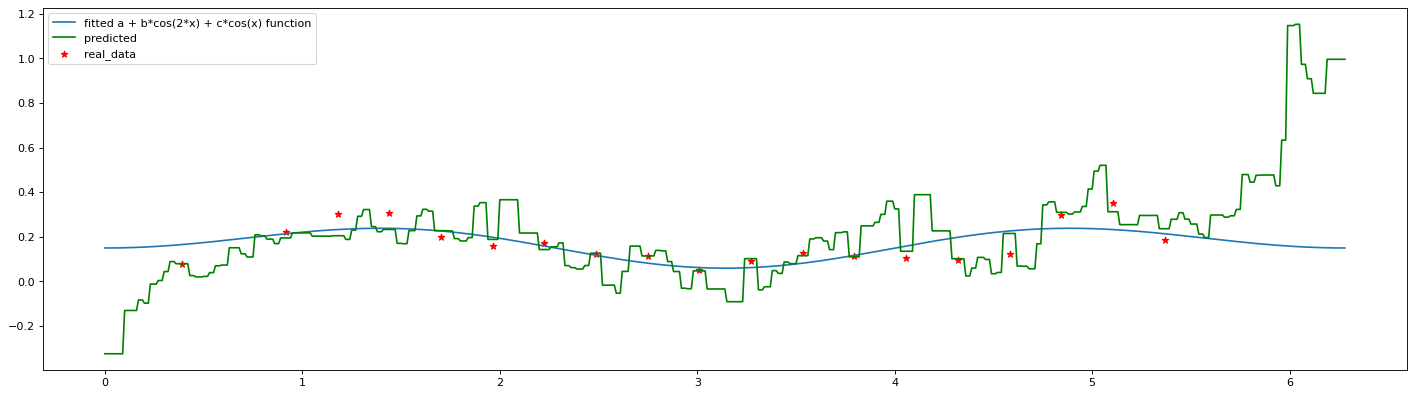

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


a = 1.1195465168419443 , b = -0.9106106293918487, c = -0.13014712242470114


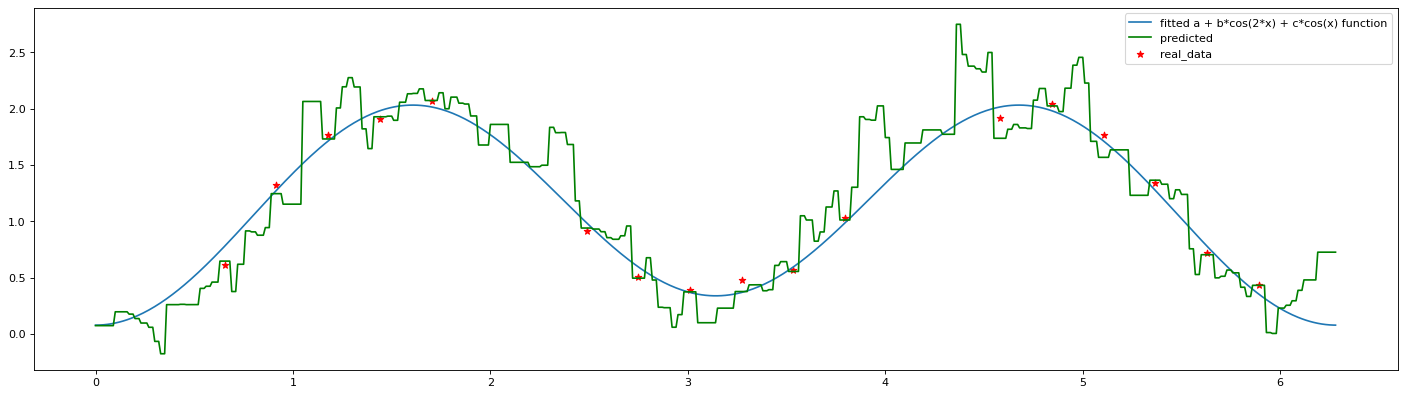

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


a = 1.6534790844884555 , b = -0.47070905930015405, c = -0.046584177845325384


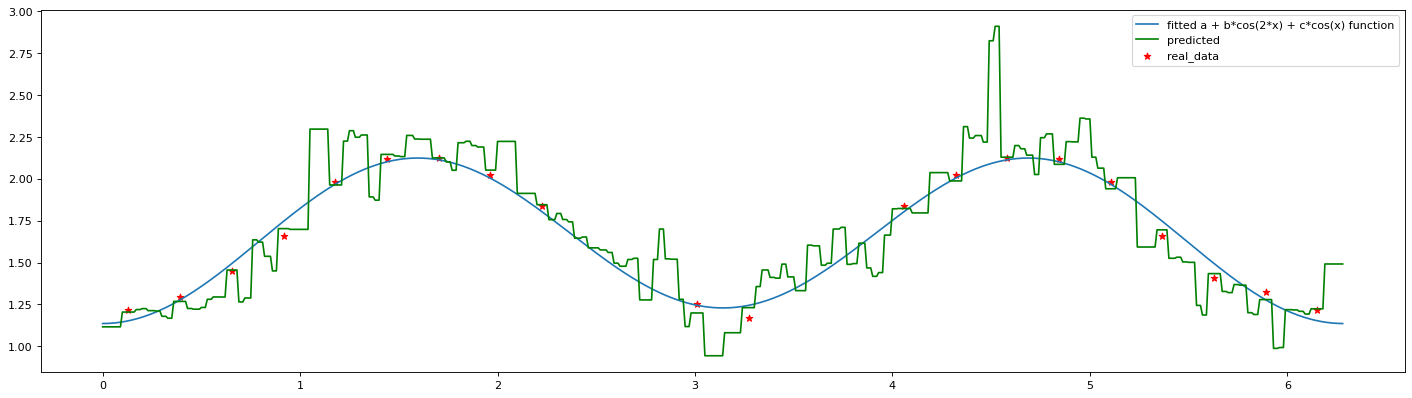

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


a = 0.6505774922167004 , b = -0.04548611840446813, c = -0.054765694950015514


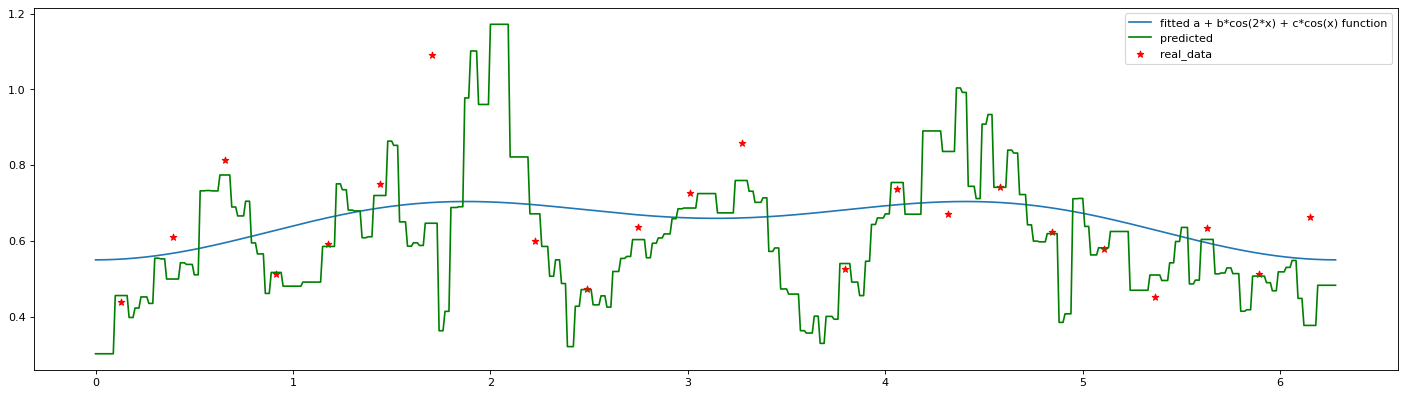

In [433]:
for i in range(1,20):
    rundom_example_check(df, randint(0, len(df)))

# Interpolate

In [185]:
from scipy import interpolate

def f_interpol(x):
    x_points = df_fix.phi.to_numpy()
    y_points = df_fix.dsigma_dOmega.to_numpy()

    tck = interpolate.splrep(x_points, y_points)
    return interpolate.splev(x, tck)

print(f_interpol(12))

982.5141389351791


In [186]:
dsigma_dOmega_interpolated = [float(f_interpol(phi)) for phi in phi_theory]

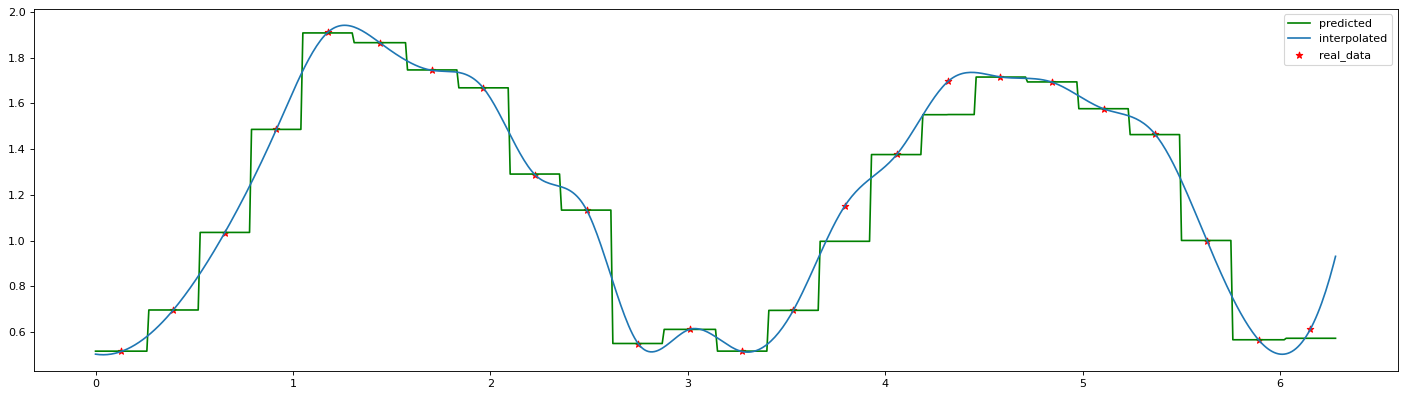

In [187]:
plt.figure(figsize=(22, 6), dpi=80)
plt.scatter(x=df_fix.phi, 
            y=df_fix.dsigma_dOmega,
            color='red', marker='*', label='real_data')
plt.plot(phi_theory, 
         dsigma_dOmega_predicted, 
         color='green', label=f'predicted')
plt.plot(phi_theory, 
         dsigma_dOmega_interpolated,
         label=f'interpolated')
plt.legend()

In [5]:
pd.read_csv('./training/csv_logs/first/1.0002/metrics.csv')

,val_loss,step,epoch,train_loss
0,1.328360,5255,0,NaN
1,NaN,5255,0,1.809547
2,0.976187,10511,1,NaN
3,NaN,10511,1,1.204659
4,0.555896,15767,2,NaN
5,NaN,15767,2,0.829765
6,0.572387,21023,3,NaN
7,NaN,21023,3,0.701498
8,0.336741,26279,4,NaN
9,NaN,26279,4,0.727887
